In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from catboost import CatBoostRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
import shap
pd.set_option('display.max_columns', None)

In [2]:
def rmsle(y_true, y_pred):
    """
    Computes the Root Mean Squared Logarithmic Error 
    
    Args:
        y_true (np.array): n-dimensional vector of ground-truth values 
        y_pred (np.array): n-dimensional vecotr of predicted values 
    
    Returns:
        A scalar float with the rmsle value 
    
    Note: You can alternatively use sklearn and just do: 
        `sklearn.metrics.mean_squared_log_error(y_true, y_pred) ** 0.5`
    """
    assert (y_true >= 0).all(), 'Received negative y_true values'
    assert (y_pred >= 0).all(), 'Received negative y_pred values'
    assert y_true.shape == y_pred.shape, 'y_true and y_pred have different shapes'
    y_true_log1p = np.log1p(y_true)  # log(1 + y_true)
    y_pred_log1p = np.log1p(y_pred)  # log(1 + y_pred)
    return np.sqrt(np.mean(np.square(y_pred_log1p - y_true_log1p)))

In [3]:
df = pd.read_csv('../../data/dataset.csv')

In [4]:
# sort by Season and Player_id
df = df.sort_values(by=['Season', 'Player_id'])
df.head()

,Player_id,Season,Games,PPG,Goals,Assists,Yellow_cards,Yellow_red_cards,Red_cards,Penalty_goals,Minutes_per_goal,Minutes_played,Club_id,Competition,MarketValue,name,age,Days_injured,international,Liga,Liga_level,W,D,L,Points,Goales_scored,Goales_conceded
10891,3132,2003,23,2.38,5,0,1,0,0,0,98.0,1034,338,Premier Liga,400000,Florin Cernat,23.0,0.0,1,Premier Liga,First Tier,23,4,3,73,68,20
37216,6893,2003,28,1.40,0,0,10,0,0,0,0.0,2308,232,Premier Liga,900000,Gabriel Tamas,20.0,18.0,1,Premier Liga,First Tier,11,7,12,40,43,44
0,10,2004,45,1.60,17,11,4,0,0,0,110.0,3244,86,Bundesliga,12000000,Miroslav Klose,26.0,0.0,1,Bundesliga,First Tier,18,5,11,59,68,37
208,65,2004,46,1.22,26,6,3,0,0,0,109.0,4015,15,Bundesliga,12000000,Dimitar Berbatov,23.0,0.0,1,Bundesliga,First Tier,16,9,9,57,65,44
429,77,2004,48,2.47,3,0,5,0,1,0,233.0,4143,27,Bundesliga,18000000,Lúcio,26.0,0.0,1,Bundesliga,First Tier,24,5,5,77,75,33




`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751



<AxesSubplot: xlabel='MarketValue', ylabel='Density'>

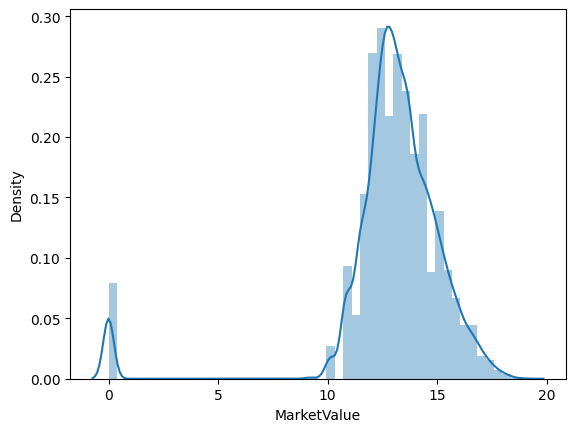

In [5]:
# plot the distribution of MarketValue
sns.distplot(np.log(df['MarketValue']+1))

In [6]:
# define categorical features
categorical_features = ['Club_id', 'Competition', 'Liga', 'Liga_level', 'international']
df[categorical_features] = df[categorical_features].astype('category')

# and drop the name column (becasue it cant handle strings that are not categorical)
df = df.drop(columns=['name'])

In [7]:
# only look at players with a marketvalue > 0.1
df = df.query('MarketValue > 0.1')

In [8]:
df.describe()

,Player_id,Season,Games,PPG,Goals,Assists,Yellow_cards,Yellow_red_cards,Red_cards,Penalty_goals,Minutes_per_goal,Minutes_played,MarketValue,age,Days_injured,W,D,L,Points,Goales_scored,Goales_conceded
count,1.716350e+05,171635.000000,171635.000000,171635.000000,171635.000000,171635.000000,171635.000000,171635.000000,171635.000000,171635.000000,171635.000000,171635.00000,1.716350e+05,171635.000000,171635.000000,171635.000000,171635.000000,171635.000000,171635.000000,171635.000000,171635.000000
mean,1.836297e+05,2015.705002,24.773554,1.340568,3.028893,1.979194,3.692784,0.115746,0.102578,0.268873,230.709377,1752.39926,2.312939e+06,24.625525,20.678131,12.915833,8.522947,11.410394,47.212562,45.187602,41.641722
std,1.668850e+05,4.436832,11.275195,0.580965,4.390511,2.725565,3.025025,0.351888,0.326852,0.910160,331.409551,995.49746,6.405703e+06,4.457790,1587.769630,5.634617,3.424327,5.347986,17.126264,16.235123,14.621136
min,1.000000e+01,2003.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.00000,1.000000e+04,14.000000,0.000000,0.000000,0.000000,0.000000,-32.000000,0.000000,0.000000
25%,5.289300e+04,2013.000000,17.000000,0.910000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,964.00000,2.500000e+05,21.000000,0.000000,9.000000,6.000000,7.000000,35.000000,34.000000,31.000000
50%,1.306220e+05,2016.000000,25.000000,1.350000,1.000000,1.000000,3.000000,0.000000,0.000000,0.000000,127.000000,1715.00000,5.000000e+05,24.000000,0.000000,12.000000,8.000000,11.000000,46.000000,44.000000,41.000000
75%,2.729030e+05,2019.000000,33.000000,1.750000,4.000000,3.000000,5.000000,0.000000,0.000000,0.000000,303.000000,2480.00000,1.700000e+06,28.000000,3.000000,16.000000,11.000000,15.000000,58.000000,55.000000,51.000000
max,1.059630e+06,2022.000000,84.000000,4.180000,73.000000,35.000000,26.000000,4.000000,5.000000,15.000000,3628.000000,6730.00000,2.000000e+08,42.000000,657380.000000,35.000000,24.000000,37.000000,113.000000,121.000000,133.000000


In [9]:
columns_to_scale = ["Games", "PPG", "Goals", "Assists", "Yellow_cards", "Red_cards", "Penalty_goals", "Minutes_per_goal",\
                    "Minutes_played", "MarketValue", "age", "Days_injured", "W", "D", "L", "Points", "Goales_scored", "Goales_conceded"]

In [10]:
df.describe()

,Player_id,Season,Games,PPG,Goals,Assists,Yellow_cards,Yellow_red_cards,Red_cards,Penalty_goals,Minutes_per_goal,Minutes_played,MarketValue,age,Days_injured,W,D,L,Points,Goales_scored,Goales_conceded
count,1.716350e+05,171635.000000,171635.000000,171635.000000,171635.000000,171635.000000,171635.000000,171635.000000,171635.000000,171635.000000,171635.000000,171635.00000,1.716350e+05,171635.000000,171635.000000,171635.000000,171635.000000,171635.000000,171635.000000,171635.000000,171635.000000
mean,1.836297e+05,2015.705002,24.773554,1.340568,3.028893,1.979194,3.692784,0.115746,0.102578,0.268873,230.709377,1752.39926,2.312939e+06,24.625525,20.678131,12.915833,8.522947,11.410394,47.212562,45.187602,41.641722
std,1.668850e+05,4.436832,11.275195,0.580965,4.390511,2.725565,3.025025,0.351888,0.326852,0.910160,331.409551,995.49746,6.405703e+06,4.457790,1587.769630,5.634617,3.424327,5.347986,17.126264,16.235123,14.621136
min,1.000000e+01,2003.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.00000,1.000000e+04,14.000000,0.000000,0.000000,0.000000,0.000000,-32.000000,0.000000,0.000000
25%,5.289300e+04,2013.000000,17.000000,0.910000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,964.00000,2.500000e+05,21.000000,0.000000,9.000000,6.000000,7.000000,35.000000,34.000000,31.000000
50%,1.306220e+05,2016.000000,25.000000,1.350000,1.000000,1.000000,3.000000,0.000000,0.000000,0.000000,127.000000,1715.00000,5.000000e+05,24.000000,0.000000,12.000000,8.000000,11.000000,46.000000,44.000000,41.000000
75%,2.729030e+05,2019.000000,33.000000,1.750000,4.000000,3.000000,5.000000,0.000000,0.000000,0.000000,303.000000,2480.00000,1.700000e+06,28.000000,3.000000,16.000000,11.000000,15.000000,58.000000,55.000000,51.000000
max,1.059630e+06,2022.000000,84.000000,4.180000,73.000000,35.000000,26.000000,4.000000,5.000000,15.000000,3628.000000,6730.00000,2.000000e+08,42.000000,657380.000000,35.000000,24.000000,37.000000,113.000000,121.000000,133.000000


In [11]:
# # split data into train and test, train is every season before 2022
# train = df[df['Season'] < 2022]
# test = df[df['Season'] == 2022]

# # scaler = StandardScaler()
# # # scale them
# # train[columns_to_scale] = scaler.fit_transform(train[columns_to_scale])
# # test[columns_to_scale] = scaler.transform(test[columns_to_scale])

# x_train = train.drop(['MarketValue'], axis=1)
# y_train = train['MarketValue']
# x_test = test.drop(['MarketValue'], axis=1)
# y_test = test['MarketValue']
# y_train = np.log10(y_train + 1)

In [12]:
# model = CatBoostRegressor(
#     n_estimators=2000,
#     learning_rate=0.05,
#     thread_count=-1,
#     max_depth=6,
#     silent=True,
#     loss_function='RMSE',
#     random_seed=42,
#     bagging_temperature=0.3,
#     od_type="Iter"
# )

In [13]:
# model.fit(x_train, y_train, cat_features=categorical_features)

In [14]:
# feature_importance = model.feature_importances_
# sorted_idx = np.argsort(feature_importance)
# fig = plt.figure(figsize=(12, 14))
# plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center')
# plt.yticks(range(len(sorted_idx)), np.array(train.drop(['MarketValue'], axis = 1).columns)[sorted_idx])
# plt.title('Feature Importance')

In [15]:
# pred = model.predict(x_test)
# pred = 10**(pred) - 1
# pred[pred < 0] = pred.mean()
# cat_rmsle = round(rmsle(y_test, pred), 2)
# print('Test RMSLE:', cat_rmsle)

In [16]:
# pred = model.predict(x_test)
# pred = 10**(pred) - 1
# # mean, std = scaler.mean_[columns_to_scale.index('MarketValue')], scaler.scale_[columns_to_scale.index('MarketValue')]
# # pred = pred * std + mean
# # y_test = y_test * std + mean

In [17]:
# pred[pred < 0] = pred.mean()
# cat_rmsle = round(rmsle(y_test, pred), 2)   
# print('Test RMSLE:', cat_rmsle) 

In [18]:
# explainer = shap.TreeExplainer(model)
# shap_values = explainer.shap_values(x_test)

In [19]:
# shap.summary_plot(shap_values, x_test)

In [20]:
# shap.decision_plot(explainer.expected_value, shap_values[-2,:], x_test.iloc[-2,:])

In [21]:
# make a scorer
from sklearn.metrics import make_scorer
rmsle_scorer = make_scorer(rmsle, greater_is_better=False)

param_grid = {
    'learning_rate': [0.01, 0.05, 0.1],
    'depth': [3, 5, 7],
    'l2_leaf_reg': [3, 5, 7],
    'n_estimators': [1000, 2000]
}
refit = True
n_jobs = -1

test_size = 0.1
n_splits = int((1//test_size)-1)
print(f"n_splits: {n_splits}")

tscv = TimeSeriesSplit(n_splits=n_splits)

model = CatBoostRegressor()

grid_search = GridSearchCV(estimator=model, param_grid=param_grid, scoring=rmsle_scorer, n_jobs=n_jobs, cv=tscv, refit=refit, verbose=10)

X = df.drop(['MarketValue'], axis=1)
y = df['MarketValue']
y = np.log10(y + 1)

n_splits: 8


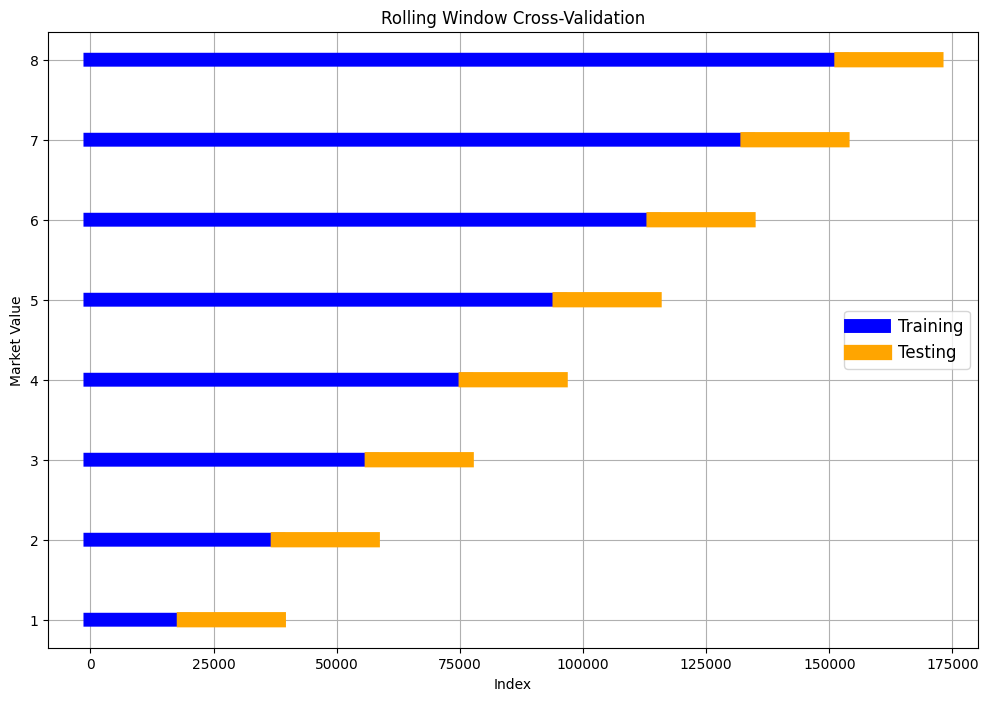

In [22]:
# plot the splits
plt.figure(figsize=(12, 8))
for i, (train_index, test_index) in enumerate(tscv.split(df)):
    # Get the training and testing data
    X_train, X_test = df.iloc[train_index], df.iloc[test_index]
    # Plot the training and testing data with thicker lines
    plt.plot(train_index, [i+1]*len(train_index), color='blue', linewidth=10)
    plt.plot(test_index, [i+1]*len(test_index), color='orange', linewidth=11)

# Add labels, grid and a legend
plt.xlabel('Index')
plt.ylabel('Market Value')
plt.title('Rolling Window Cross-Validation')
plt.grid(True)
plt.legend(['Training', 'Testing'], loc="center right" ,fontsize='large')
plt.show()

In [23]:
grid_search.fit(X, y, cat_features=categorical_features)
print(f'Model: {model} best params are: {grid_search.best_params_}')

Fitting 8 folds for each of 54 candidates, totalling 432 fits
0:	learn: 0.6267694	total: 218ms	remaining: 7m 16s
1:	learn: 0.6075096	total: 298ms	remaining: 4m 57s
2:	learn: 0.5898612	total: 376ms	remaining: 4m 10s
3:	learn: 0.5732326	total: 444ms	remaining: 3m 41s
4:	learn: 0.5573958	total: 522ms	remaining: 3m 28s
5:	learn: 0.5426930	total: 592ms	remaining: 3m 16s
6:	learn: 0.5290635	total: 665ms	remaining: 3m 9s
7:	learn: 0.5158999	total: 748ms	remaining: 3m 6s
8:	learn: 0.5032577	total: 822ms	remaining: 3m 1s
9:	learn: 0.4914188	total: 894ms	remaining: 2m 57s
10:	learn: 0.4801527	total: 970ms	remaining: 2m 55s
11:	learn: 0.4698688	total: 1.05s	remaining: 2m 54s
12:	learn: 0.4602858	total: 1.13s	remaining: 2m 53s
13:	learn: 0.4512032	total: 1.22s	remaining: 2m 53s
14:	learn: 0.4412259	total: 1.29s	remaining: 2m 51s
15:	learn: 0.4320194	total: 1.36s	remaining: 2m 49s
16:	learn: 0.4234155	total: 1.43s	remaining: 2m 47s
17:	learn: 0.4154766	total: 1.5s	remaining: 2m 44s
18:	learn: 0.407

In [24]:
best_model = grid_search.best_estimator_
# save the model
best_model.save_model('catboost_model.cbm')

In [25]:
# scores = []
# X = df.drop(['MarketValue'], axis=1)
# y = df['MarketValue']

# for i, (train_index, test_index) in enumerate(tscv.split(df)):
#     # Get the training and testing data
#     X_train, y_train = X.iloc[train_index], y.iloc[train_index]
#     X_test, y_test = X.iloc[test_index], y.iloc[test_index]
    
#     # scale the target
#     y_train = np.log10(y_train + 1)

#     # train and predict
#     model.fit(X_train, y_train, cat_features=categorical_features)
#     pred = model.predict(X_test)
#     pred = 10**(pred) - 1
#     pred[pred < 0] = pred.mean()
#     cat_rmsle = round(rmsle(y_test, pred), 2)
#     scores.append(cat_rmsle)

#     print(f"Fold {i+1} RMSLE: {cat_rmsle}")

# print('Mean Test RMSLE over all folds:', np.mean(scores))

# # plot the scores
# plt.figure(figsize=(12, 8))
# plt.plot(range(1, n_splits+1), scores, color='blue')
# plt.xlabel('Split')
# plt.ylabel('RMSLE')
# plt.title('Rolling Window Cross-Validation')
# plt.show()